In [1]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2


import torch, datetime, click, pickle, numpy as np
from tqdm import tqdm

torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *
from data_mgmt import get_paths, get_ids
from plot import plot_losses
from predict import Predict
from pyrofit.lensing.distributions import get_default_shmf


import matplotlib.pyplot as plt 

from plot import *



DEVICE = 'cuda'

In [2]:
# Set definitions (should go to click)
m = 1
nsub = 1
nsim = 500

nmc = 3
sigma = 0.0
npred = 0

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 10

simul = 'real'

{'m': 1, 'nsub': 1, 'nsim': 500, 'nmc': 3, 'sigma': 0.0, 'npred': 0, 'simul': 'real'}
Loading existing store.
Store has 492 simulations.
Loading ../data/mre/mre_real_m_1_nsub_1_nsim_500_sigma_0.0_nmc_3.pt!
3


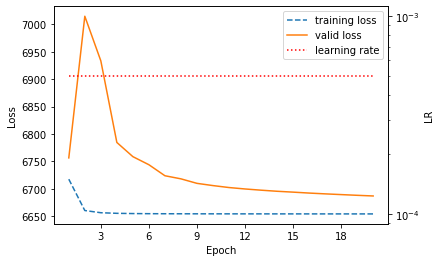

In [3]:
time_start = datetime.datetime.now()


def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

# Set definitions (should go to click)
systemname = "ngc4414"


# Set utilities
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,simul=simul)
print(entry)
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(systemname, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
#     print(f'Image has L = {L}.')

dataset = swyft.Dataset.load(
    filename=dataset_path,
    store=store,
    simhook = noise
)

# Load network
print(f'Loading {mre_path}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
#         L = L,
    nmc = nmc, 
#         lows = lows,
#         highs = highs,
    marginal_classifier = CustomMarginalClassifier,
    parameter_transform = CustomParameterTransform(nmc, L, lows, highs),
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

plot_losses(mre, save_name = get_ids(entry)[2])

In [29]:
import torch, numpy as np
from pyrofit.lensing.distributions import get_default_shmf


class Prior():
    def __init__(self, nsub, nmc, lows, highs, L):
        self.nsub = nsub
        self.nmc  = nmc
        self.lows = lows
        self.highs = highs
        self.L = L
        
        self.m_centers, self.m_edges = self.get_m()
    
    def get_m(self):
        m = torch.logspace(self.lows[-1], self.highs[-1], 2*self.nmc+1)
        m_centers, m_edges = m[1::2], m[0::2]
        return m_centers, m_edges
    
    def __call__(self):
        
        a, b = self.lows[-1], self.highs[-1]
        shmf = get_default_shmf(z_lens = 0.5, log_range = (a, b))
        bins = torch.logspace(start = a, end = b, steps = 100)
        sample = shmf.sample((pow(10,8),)).numpy()
        print("Sampling SHMF, this should NOT happen more than once!!!")
        hist, _ = np.histogram(sample, bins = bins, density = True)
        
        m_edges_idx = torch.tensor([(bins - m_edge).abs().argmin() for m_edge in self.m_edges])
        shmf_frac = np.array([sum((torch.diff(bins)*hist)[i:j]) for i, j in zip(m_edges_idx[:-1], m_edges_idx[1:])])
        
        
        priors = self.nsub / (self.L*self.L) * shmf_frac
        prior0 = 1 - priors
        prior1 = priors
        print('Prior subhalo in Mass range')
        for m_left, m_right, prior in zip(self.m_edges[:-1], self.m_edges[1:], priors):
            print(f"{prior/(self.nsub / (self.L*self.L)):.2e} \t [{m_left:.2e} - {m_right:.2e}]")

        return prior0, prior1, np.concatenate((prior0, prior1))
    

class Predict():
    def __init__(self, entry, lows, highs, L, dataset, mre):
        
        self.dataset = dataset
        self.mre = mre
       
        self.L = L
        nsub = entry['nsub']
        self.nmc = entry['nmc']
        
        prior  = Prior(nsub, self.nmc, lows, highs, L)
        _, _, self.priors = prior()
                
        self.coord_empty, self.coord_full = self.get_empty_and_full_coords(lows, highs, prior.m_centers, L)
#         _, _, self.priors = self.get_priors(nsub, lows, highs, L, self.nmc, m_edges)
                
        
    def get_empty_and_full_coords(self, lows, highs, m_centers, L):
        grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
        x, y = torch.meshgrid(grid, grid, indexing = 'xy')
#         m = torch.logspace(lows[-1], highs[-1], 2*nmc+1)
#         m_centers, m_edges = m[1::2], m[0::2]
        ms = [torch.full((L*L,), m_i) for m_i in m_centers]

        coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
        coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

        return coord_empty, coord_full
    

    
    def get_obs(self, dataset, obs0_i = -1):
        obs0_i = np.random.randint(0, len(dataset)) if obs0_i == -1 else obs0_i

        obs0 = dataset[obs0_i][0]
        v0 = dataset[obs0_i][2]

        obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
        v0 = v0.unsqueeze(0).to(DEVICE)

        return obs0, v0, obs0_i
    
    def __call__(self, obs0_i = -1):
    
        # Get observation and targets
        obs0, v0, obs0_i = self.get_obs(self.dataset, obs0_i)
        targets = self.mre.network.parameter_transform(v0).squeeze()
        target = targets[self.nmc :].numpy()
#         print(targets.shape, target.shape)
        

        # Get logratios
        logratios = np.zeros((self.nmc *2, self.L, self.L))
        logratios[:self.nmc ] = self.mre.network(obs0, self.coord_empty).view(self.nmc, self.L, self.L)
        logratios[self.nmc :] = self.mre.network(obs0, self.coord_full).view(self.nmc, self.L, self.L)
                
        
        # Posterior 
        posts = np.exp(logratios) * (self.priors)[:, np.newaxis, np.newaxis] 
        posts_sum = np.sum(posts.reshape(2, self.nmc, self.L, self.L).transpose([1,0,2,3]), axis = 1)
        posts_sum = np.tile(posts_sum, (2,1,1))
        posts_norm = posts / posts_sum
        post_norm = posts_norm[self.nmc :]

        obs0 = obs0['image'].squeeze().numpy()
        v0 = v0.numpy()

        return post_norm, target, obs0, v0, obs0_i
    
predict = Predict(entry, lows, highs, L, dataset, mre)


Sampling SHMF, this should NOT happen more than once!!!
Prior subhalo in Mass range
7.45e-01 	 [1.00e+10 - 4.64e+10]
2.02e-01 	 [4.64e+10 - 2.15e+11]
5.26e-02 	 [2.15e+11 - 1.00e+12]


In [14]:
a, b = lows[-1], highs[-1]
shmf = get_default_shmf(z_lens = 0.5, log_range = (a, b))
bins = torch.logspace(start = a, end = b, steps = 100)
sample = shmf.sample((pow(10,6),)).numpy()

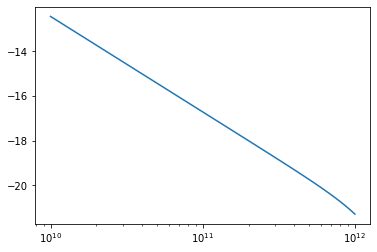

In [22]:
plt.plot(bins, shmf._log_prob(bins))
plt.xscale('log')


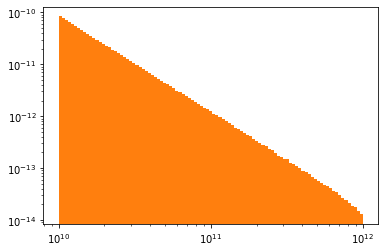

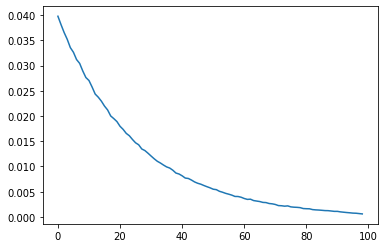

In [27]:
plt.plot(bins, shmf._log_prob(bins)*10**7)

h, _, _ = plt.hist(sample, bins = bins, density = True)
# plt.plot(bins[1:], h)
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(np.diff(bins)*h)
plt.show()

In [6]:
# Get predictions
predict = Predict(entry, lows, highs, L, dataset, mre)
post, target, obs0, v0, obs0_i = predict()

if npred == 0: npred = len(dataset) 

pred = {
    'post':   np.zeros((npred, *post.shape)),
    'target': np.zeros((npred, *target.shape)),
    'obs0':   np.zeros((npred, *obs0.shape)),
    'v0':     np.zeros((npred, *v0.shape)),
    'obs0_i': np.zeros((npred)),
}

for i in tqdm(range(npred), mininterval = 1):
    for name, var in zip(pred.keys(), predict()):
        pred[name][i] = var

with open(pred_path, 'wb') as f:
    pickle.dump(pred, f)

print_duration('Prediction', time_start)

Prior subhalo in Mass range
4.66e-04 	 [1.00e+10 - 4.64e+10]
1.26e-04 	 [4.64e+10 - 2.15e+11]
3.29e-05 	 [2.15e+11 - 1.00e+12]


100%|██████████| 492/492 [00:07<00:00, 64.83it/s]

Prediction Done!
Total creating time is 0:00:19! 
 
 


In [7]:
pred.keys()

dict_keys(['post', 'target', 'obs0', 'v0', 'obs0_i'])